<ipython-input-26-dca0db3ef014>:32: RuntimeWarning: invalid value encountered in true_divide
  sc[:,:,i] = (sc[:,:,i] - np.min(sc[:,:,i]))/ (np.max(sc[:,:,i]) - np.min(sc[:,:,i]))


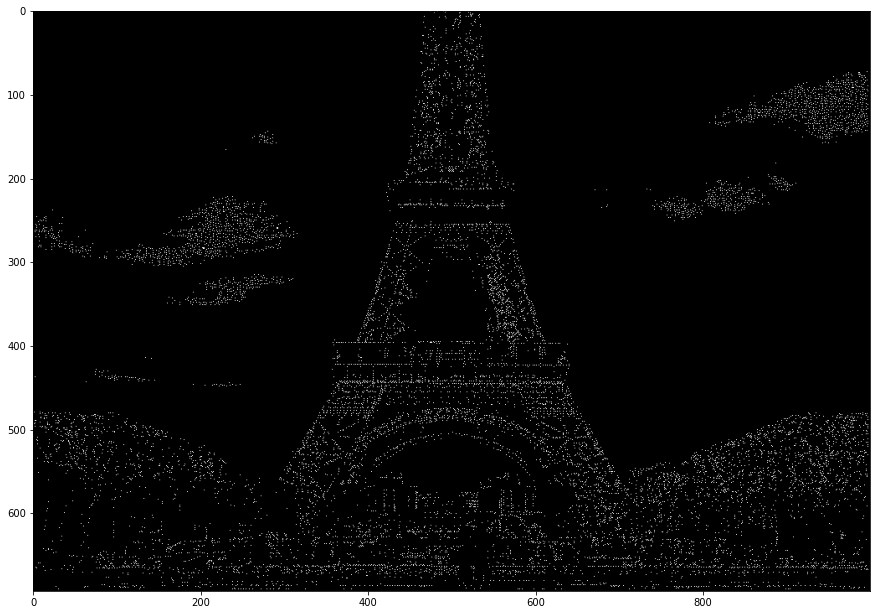

In [26]:
import numpy as np
from scipy import signal
import skimage.transform
import skimage.io
from skimage.color import rgb2gray
import cv2
import matplotlib.pyplot as plt

def gaussian_filtered(img, sigma, mask_size):
# Normalize pixel intensities for feature to become more identifiable
  img = (img - np.min(img)) / (np.max(img) - np.min(img))

  X, y = np.meshgrid(np.arange(-mask_size//2+1,mask_size//2+2), np.arange(-mask_size//2+1,mask_size//2+2))

  gauss_filter = np.exp(-(X**2+y**2)/(2*sigma**2)/(2*np.pi*sigma**2))
  
  filtered_img = signal.convolve2d(img, gauss_filter,boundary = "symm", mode="same")

  filtered_img = (filtered_img - np.min(filtered_img)) / (np.max(filtered_img)-np.min(filtered_img))*255
  return filtered_img

def SIFT(img, scale_space_size):
  k = 2**(1/scale_space_size-1)
  sigma = 1
  mask_size = 5
  m,n = img.shape
 
  sc = np.zeros((m,n, scale_space_size))

  for i in range(scale_space_size-1):
    sc[:,:,i] = gaussian_filtered(img, k**(i+1)*sigma, mask_size) - gaussian_filtered(img, k**(i)*sigma, mask_size)
    sc[:,:,i] = (sc[:,:,i] - np.min(sc[:,:,i]))/ (np.max(sc[:,:,i]) - np.min(sc[:,:,i]))
  
  window_size = 3
  sift_features = np.zeros((m,n))

  # Detect SIFT features by finding extrema in DoG octave
  for i in range(window_size//2, m - window_size//2):
      for j in range(window_size//2, n - window_size//2):
          op_temp1 = sc[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1, 0]
          op_temp2 = sc[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1, 1]
          op_temp3 = sc[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1, 2]

          if max(op_temp1.max(), op_temp2.max(), op_temp3.max()) == op_temp2[1, 1] or min(op_temp1.min(),op_temp2.min(),op_temp3.min()) == op_temp2[1, 1]:
              sift_features[i - int(window_size // 2), j - int(window_size // 2)] = 255

  return sift_features

def SIFT_in_Modified_Images(ip_image, scaling):
  ip_image_rotate = skimage.transform.rotate(ip_image, 60, resize=True)
  sift1 = SIFT(ip_image_rotate, 5)

  ip_image_noisy_guassian = skimage.util.random_noise(ip_image, mode='gaussian')
  sift2 = SIFT(ip_image_noisy_guassian, 5)

  ip_image_noisy_salt_pepper = skimage.util.random_noise(ip_image, mode='s&p')
  sift3 = SIFT(ip_image_noisy_salt_pepper, 5)

  ip_image_rescale = skimage.transform.rescale(ip_image, scaling)
  sift4 = SIFT(ip_image_rescale, 5)

  ip_image_blur= cv2.GaussianBlur(ip_image, (7, 7), 0)
  sift5=SIFT(ip_image_blur,5)

  return

img = skimage.io.imread("/content/Eifel Tower.jfif")
gray_img = rgb2gray(img)
img = SIFT(gray_img, 5)

# Display image
plt.figure(figsize=(15,15))
plt.imshow(img, cmap='gray')
plt.show()